In [51]:
# Use seaborn for pairplot
!pip install -q seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution1D, Dropout
from sklearn import metrics
print(tf.__version__)

2.7.0


In [52]:
path = '/content/Emax.csv'
names = ['coil turns of single wing',	'coil thickness',	'coil diameter',	'distance between two wings',	'distance between head and coil position',	'angle between two coils',	'electric field']
raw_dataset = pd.read_csv(path, names=names)

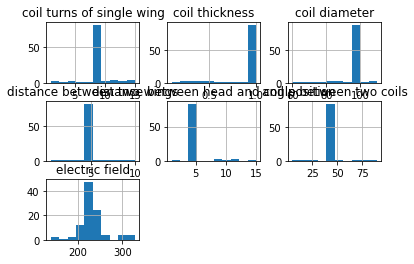

In [53]:
# plot histogram
raw_dataset.hist()
plt.show()

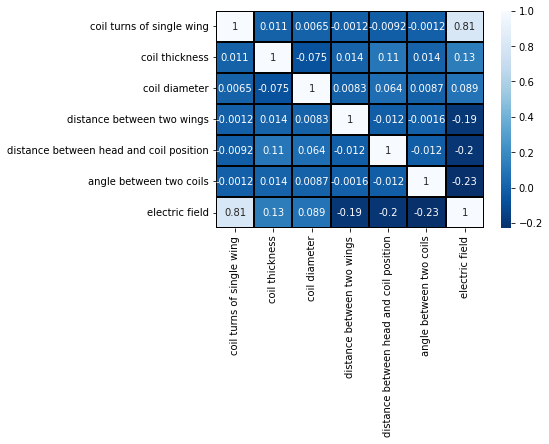

In [54]:
# plot correlation matrix
correlations = raw_dataset.corr()
sns.heatmap(correlations, annot = True, cmap ='Blues_r', 
            linecolor ='black', linewidths = 1)

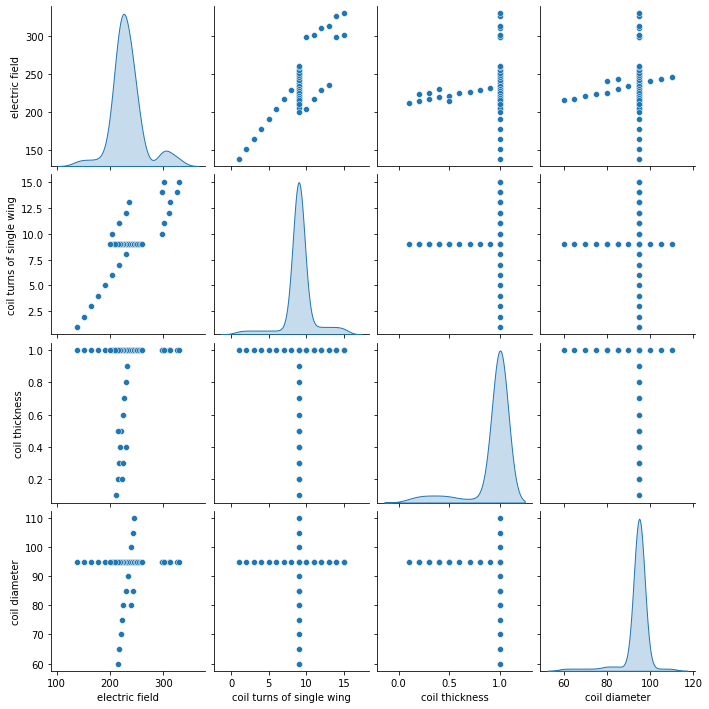

In [55]:
sns.pairplot(raw_dataset[['electric field','coil turns of single wing', 'coil thickness', 'coil diameter']], diag_kind='kde')

In [56]:
dataset = raw_dataset.copy()
mean = dataset.mean(axis=0)
std = dataset.std(axis=0)
features = (dataset - mean) / std
train = features.sample(frac=0.8, random_state=0)
test = features.drop(train.index)
train_features = train.copy()
test_features = test.copy()
train_labels = train.pop('electric field')
test_labels = test.pop('electric field')
print(train_features.shape)
print(train_features.shape[0])
print(train_features.shape[1])

(80, 7)
80
7


In [57]:
sample_size = train_features.shape[0] # number of samples in train set
time_steps  = train_features.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = train_features.values.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("one Sample shape:\n",train_data_reshaped[0].shape)
print("An example sample:\n", train_data_reshaped[0])

After reshape train data set shape:
 (80, 7, 1)
one Sample shape:
 (7, 1)
An example sample:
 [[-0.0304003 ]
 [-1.61945777]
 [ 0.21257653]
 [-0.03846844]
 [-0.29929772]
 [-0.04052898]
 [-0.24739395]]


In [58]:
test_data_reshaped = test_features.values.reshape(test_features.shape[0],test_features.shape[1],1)

In [59]:
def conv1D_model():

  n_timesteps = train_data_reshaped.shape[1] #6
  n_features  = train_data_reshaped.shape[2] #1 
  model = keras.Sequential(name="conv1D_model")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu', name="Conv1D_2"))
  model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
  model.add(keras.layers.Dense(n_features, name="Dense_2"))
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae'])
  return model

model_conv1D = conv1D_model()
model_conv1D.summary()

Model: "conv1D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 6, 64)             192       
                                                                 
 Conv1D_2 (Conv1D)           (None, 5, 32)             4128      
                                                                 
 Conv1D_3 (Conv1D)           (None, 4, 16)             1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 2, 16)            0         
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 Dense_1 (Dense)             (None, 32)                1056      
                                                                 
 Dense_2 (Dense)             (None, 1)                

In [60]:
history = model_conv1D.fit(train_data_reshaped, train_labels, epochs=100,
                    validation_split=0.2, verbose=0)

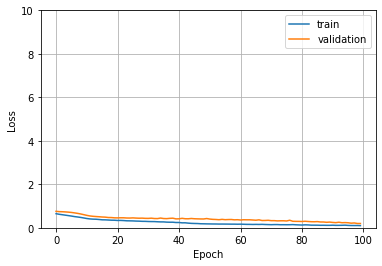

In [61]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.ylim([0, 10]) 
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
plot_loss(history)

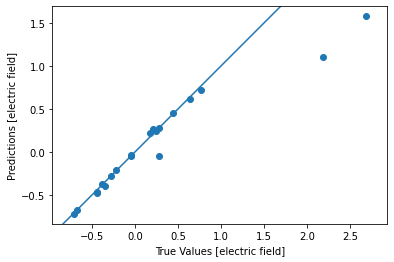

In [62]:
test_predictions = model_conv1D.predict(test_data_reshaped).flatten()

def plot_prediction(test_labels, test_predictions):
  plt.figure()
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [electric field]')
  plt.ylabel('Predictions [electric field]')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  _ = plt.plot([-100, 100],[-100,100])

plot_prediction(test_labels, test_predictions)

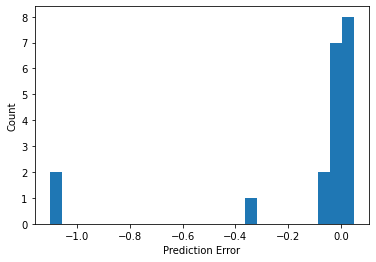

In [63]:
  test_predictions = model_conv1D.predict(test_data_reshaped).flatten()
  error = test_predictions - test_labels
  plt.hist(error, bins = 25)
  plt.xlabel("Prediction Error")
  _ = plt.ylabel("Count")

In [64]:
# 1D_CNN Model Evaluation
print('R^2:',metrics.r2_score(test_labels, test_predictions))
print('MAE:',metrics.mean_absolute_error(test_labels, test_predictions))
print('MSE:',metrics.mean_squared_error(test_labels, test_predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(test_labels, test_predictions)))

R^2: 0.823871776749814
MAE: 0.14189203457273125
MSE: 0.12571283790505144
RMSE: 0.3545600624789141
